In [1]:
# installing lightgbm package in notebook conda_mxnet_p36
# comment if already installed
!pip install lightgbm

from lightgbm.sklearn import LGBMRegressor
import numpy as np
import pandas as pd
from scipy.stats import entropy, kurtosis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# if not using AWS uncomment the following
# and hide the following lines
#train = pd.read_csv('path/to/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

# imports and functions for sagemaker
import boto3
from sagemaker import get_execution_role
role = get_execution_role()
region = boto3.Session().region_name
bucket='lanl-capstone' # s3 bucket name 
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

train = pd.read_csv(bucket_path + '/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


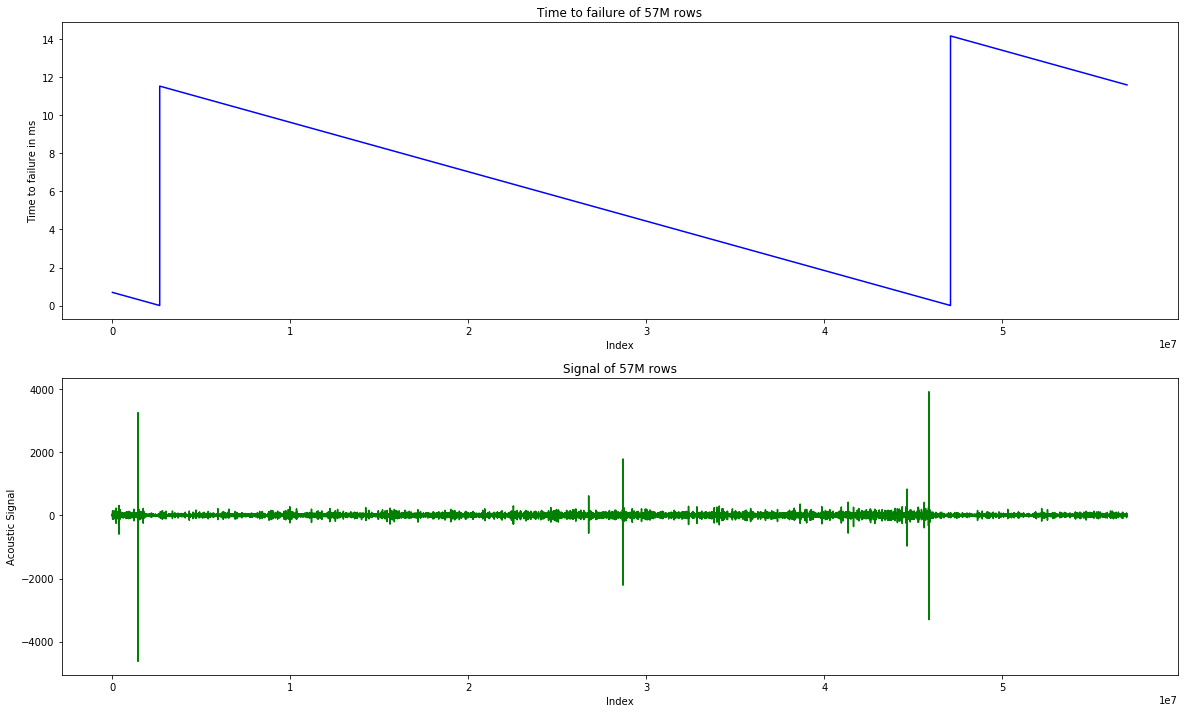

In [2]:
# Creation of values for visualization of 2 quakes
acoustic_visualisation = train['acoustic_data'][3000000:60000000].values
time_to_failure_visualisation = train['time_to_failure'][3000000:60000000].values

# Graphs for visualization
fig, ax = plt.subplots(2,1, figsize=(20,12))
ax[0].plot(time_to_failure_visualisation, c="blue")
ax[0].set_title("Time to failure of 57M rows")
ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to failure in ms");
ax[1].plot(acoustic_visualisation, c="green")
ax[1].set_title("Signal of 57M rows")
ax[1].set_xlabel("Index")
ax[1].set_ylabel("Acoustic Signal");

In [3]:
# TRAINING DATASET INTO SUBSET TRAIN AND SUBSET TEST

# assign the first 60M rows as testing datas
acoustic_subset_test = train['acoustic_data'][:60000000].values
time_to_failure_subset_test= train['time_to_failure'][:60000000].values

# assign the remaining rows as traing datas
acoustic_subset_train = train['acoustic_data'][60000000:].values
time_to_failure_subset_train = train['time_to_failure'][60000000:].values

# shapes of the subsets
print('shape training subset acoustic: ', acoustic_subset_train.shape)
print('shape training subset time to failure: ', time_to_failure_subset_train.shape)

# the total of rows that will be taken in account while computation as segments_subsets won't take in account
# the last 45480 rows (because of the division by 'step')
total_size_train_data = 569100000

acoustic_subset_train = acoustic_subset_train[:total_size_train_data]
time_to_failure_subset_train = time_to_failure_subset_train[:total_size_train_data]

# Values to be implemented
step = 150000
segments_subset = int(np.floor(len(acoustic_subset_train)/step))
segments_subset_test = int(np.floor(len(acoustic_subset_test)/step))

# for better precision
pd.options.display.precision = 15

shape training subset acoustic:  (569145480,)
shape training subset time to failure:  (569145480,)


In [4]:
# Reshaping the acoustic datas 
acoustic_subset_train = np.reshape(acoustic_subset_train, (segments_subset, step)).transpose()
acoustic_subset_test = np.reshape(acoustic_subset_test, (segments_subset_test, step)).transpose()

print('acoustic_subset_train shape: ', acoustic_subset_train.shape)
print('acoustic_subset_test shape: ', acoustic_subset_test.shape)

# transforming the ndarrays into DataFrames
acoustic_subset_train = pd.DataFrame(data=acoustic_subset_train, index=range(step), columns=range(segments_subset))
time_to_failure_subset_train = pd.DataFrame(data=time_to_failure_subset_train, index=range(total_size_train_data), columns=['time_to_failure'])
acoustic_subset_test = pd.DataFrame(data=acoustic_subset_test, index=range(step), columns=range(segments_subset_test))
time_to_failure_subset_test = pd.DataFrame(data=time_to_failure_subset_test, index=range(60000000), columns=['time_to_failure'])

acoustic_subset_train shape:  (150000, 3794)
acoustic_subset_test shape:  (150000, 400)


In [5]:
# Creation of the training dataset subset

# percentages to use for computation
percentages = [0.05,0.1,0.25,0.4,0.5,0.6,0.75,0.9,0.95]

# names for the differents dataframes
max_names = ['max_0.05', 'max_0.1', 'max_0.25', 'max_0.4', 'max_0.5', 'max_0.6', 'max_0.75', 'max_0.9', 'max_0.95']
min_names = ['min_0.05', 'min_0.1', 'min_0.25', 'min_0.4', 'min_0.5', 'min_0.6', 'min_0.75', 'min_0.9', 'min_0.95']
std_names = ['std_0.05', 'std_0.1', 'std_0.25', 'std_0.4', 'std_0.5', 'std_0.6', 'std_0.75', 'std_0.9', 'std_0.95']
med_names = ['med_0.05', 'med_0.1', 'med_0.25', 'med_0.4', 'med_0.5', 'med_0.6', 'med_0.75', 'med_0.9', 'med_0.95']
mean_names = ['mean_0.05', 'mean_0.1', 'mean_0.25', 'mean_0.4', 'mean_0.5', 'mean_0.6', 'mean_0.75', 'mean_0.9', 'mean_0.95']
kur_names = ['kur_0.05', 'kur_0.1', 'kur_0.25', 'kur_0.4', 'kur_0.5', 'kur_0.6', 'kur_0.75', 'kur_0.9', 'kur_0.95']
shan_names = ['shan_0.05', 'shan_0.1', 'shan_0.25', 'shan_0.4', 'shan_0.5', 'shan_0.6', 'shan_0.75', 'shan_0.9', 'shan_0.95']

# empty dataframes
X_subset_train_max = pd.DataFrame(index=range(segments_subset), dtype=np.float64, columns=max_names)
X_subset_train_min = pd.DataFrame(index=range(segments_subset), dtype=np.float64, columns=min_names)
X_subset_train_std = pd.DataFrame(index=range(segments_subset), dtype=np.float64, columns=std_names)
X_subset_train_med = pd.DataFrame(index=range(segments_subset), dtype=np.float64, columns=med_names)
X_subset_train_mean = pd.DataFrame(index=range(segments_subset), dtype=np.float64, columns=mean_names)
X_subset_train_kur = pd.DataFrame(index=range(segments_subset), dtype=np.float64, columns=kur_names)
X_subset_train_shan = pd.DataFrame(index=range(segments_subset), dtype=np.float64, columns=shan_names)

y_subset_train = pd.DataFrame(index=range(segments_subset), dtype=np.float64, columns=['time_to_failure'])


# loop through the 3794 columns 
for idx in range(segments_subset):
    # each 150000 rows we take the last value and assign it to y_subset_train according to the index
    seg = time_to_failure_subset_train.iloc[idx*step:idx*step+step]
    y_subset_train.loc[idx, 'time_to_failure'] = float(seg['time_to_failure'].values[-1])
    
    # loop through all the percentages 
    for perc in percentages:
        # for each column the first perc is computed and the following operations are performed
        vec_to_compute = acoustic_subset_train[idx][:int(perc*step)]
        X_subset_train_max['max_' + str(perc)][idx] = float(np.max(vec_to_compute))
        X_subset_train_min['min_' + str(perc)][idx] = float(np.min(vec_to_compute))
        X_subset_train_std['std_' + str(perc)][idx] = float(np.std(vec_to_compute))
        X_subset_train_med['med_' + str(perc)][idx] = float(np.median(vec_to_compute))
        X_subset_train_mean['mean_' + str(perc)][idx] = float(np.mean(vec_to_compute))
        X_subset_train_kur['kur_' + str(perc)][idx] = float(kurtosis(vec_to_compute))
        X_subset_train_shan['shan_' + str(perc)][idx] = float(entropy(np.unique(vec_to_compute, return_counts=True)[1]))

# concatenating all the dataframes       
frames_subset_train = [X_subset_train_max, X_subset_train_min, X_subset_train_std, X_subset_train_med, X_subset_train_mean, X_subset_train_kur, X_subset_train_shan]
X_subset_train = pd.concat(frames_subset_train, axis = 1)
X_subset_train

,max_0.05,max_0.1,max_0.25,max_0.4,max_0.5,max_0.6,max_0.75,max_0.9,max_0.95,min_0.05,...,kur_0.95,shan_0.05,shan_0.1,shan_0.25,shan_0.4,shan_0.5,shan_0.6,shan_0.75,shan_0.9,shan_0.95
0,16.0,17.0,50.0,50.0,50.0,138.0,138.0,138.0,138.0,-6.0,...,71.058167070637268,2.459093841906198,2.464381450151275,2.610600624116921,2.629680130598539,2.607464433012424,2.677565951251498,2.658833497880297,2.643353056978392,2.656352747713936
1,49.0,49.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0,-34.0,...,173.381592061616658,2.861682985186366,2.861339578200799,2.845626493831974,2.758041679140235,2.737502576045435,2.710922360436948,2.669361669684696,2.648690722749579,2.637626950699174
2,77.0,77.0,77.0,135.0,135.0,135.0,135.0,151.0,151.0,-38.0,...,95.263154323050472,2.935289139463591,2.719929341265990,2.721442720246815,2.834523894286764,2.774060978676317,2.747403992345516,2.744906253223535,2.768898751342701,2.764097008264278
3,37.0,45.0,84.0,84.0,84.0,105.0,105.0,105.0,105.0,-39.0,...,64.073840533423578,2.759890148659935,2.841989833411614,2.811921521922474,2.704310243964350,2.693718643159383,2.746602768926560,2.723260690499785,2.713634748795687,2.721204762381878
4,20.0,52.0,52.0,52.0,52.0,74.0,74.0,74.0,74.0,-11.0,...,24.091942802879380,2.595308318410110,2.772015802409310,2.716862770719831,2.671196546177976,2.681463472945547,2.724450693935337,2.681605452355856,2.651234067532446,2.646142646421092
5,17.0,42.0,42.0,132.0,132.0,132.0,132.0,132.0,132.0,-7.0,...,109.553141842981049,2.522396574323120,2.768857890914308,2.683843394767231,2.737449056176862,2.717518025980547,2.725517311776196,2.704521197651980,2.672781089351170,2.663770110259366
6,26.0,26.0,44.0,44.0,138.0,138.0,138.0,138.0,138.0,-12.0,...,70.728152559320819,2.668885873581654,2.596397316358738,2.603561276805699,2.600458176439804,2.661192019711027,2.649154525545104,2.659608330181135,2.682467200099988,2.674481262609155
7,17.0,17.0,38.0,47.0,47.0,47.0,88.0,88.0,88.0,-6.0,...,26.722301570734050,2.487648406905192,2.485303000843856,2.552437069340363,2.617264859383966,2.609512104895267,2.615259179234362,2.625438827093995,2.657793613329340,2.659104124024123
8,17.0,35.0,78.0,78.0,78.0,98.0,98.0,98.0,98.0,-6.0,...,40.173986578099523,2.441643084400307,2.669264582047445,2.849844955302860,2.761098025139257,2.734050377239946,2.752935494334750,2.756901441913895,2.757557669277578,2.763508559959413
9,35.0,92.0,121.0,126.0,126.0,180.0,180.0,180.0,180.0,-34.0,...,103.221925386768305,2.757344783737091,2.782972412999116,2.902630157760636,2.851136799587600,2.805614765533754,2.856283742729691,2.827555019370501,2.847172331030194,2.828411070989559


In [7]:
# First 2 rows of the simple dataframe X_train_max
X_subset_train_max.head(2)

,max_0.05,max_0.1,max_0.25,max_0.4,max_0.5,max_0.6,max_0.75,max_0.9,max_0.95
0,16.0,17.0,50.0,50.0,50.0,138.0,138.0,138.0,138.0
1,49.0,49.0,193.0,193.0,193.0,193.0,193.0,193.0,193.0


In [8]:
y_subset_train

,time_to_failure
0,11.566399712999999
1,11.528096915000001
2,11.488698622000001
3,11.450395824000001
4,11.411097530999999
5,11.371699238000000
6,11.333396440000000
7,11.293998147000000
8,11.254599854000000
9,11.216297055999998


In [9]:
# Creation of subset test from training data

# empty dataframes
X_subset_test_max = pd.DataFrame(index=range(segments_subset_test), dtype=np.float64, columns=max_names)
X_subset_test_min = pd.DataFrame(index=range(segments_subset_test), dtype=np.float64, columns=min_names)
X_subset_test_std = pd.DataFrame(index=range(segments_subset_test), dtype=np.float64, columns=std_names)
X_subset_test_med = pd.DataFrame(index=range(segments_subset_test), dtype=np.float64, columns=med_names)
X_subset_test_mean = pd.DataFrame(index=range(segments_subset_test), dtype=np.float64, columns=mean_names)
X_subset_test_kur = pd.DataFrame(index=range(segments_subset_test), dtype=np.float64, columns=kur_names)
X_subset_test_shan = pd.DataFrame(index=range(segments_subset_test), dtype=np.float64, columns=shan_names)

y_subset_test = pd.DataFrame(index=range(segments_subset_test), dtype=np.float64, columns=['time_to_failure'])

# loop through the 400 columns 
for idx in range(segments_subset_test):
    # each 150000 rows we take the last value and assign it to y_subset_test according to the index
    seg = time_to_failure_subset_test.iloc[idx*step:idx*step+step]
    y_subset_test.loc[idx, 'time_to_failure'] = float(seg['time_to_failure'].values[-1])

    # loop through the list of percentages 
    for perc in percentages:
        # for each column the first perc is computed and the following operations are performed
        vec_to_compute = acoustic_subset_test[idx][:int(perc*step)]
        X_subset_test_max['max_' + str(perc)][idx] = float(np.max(vec_to_compute))
        X_subset_test_min['min_' + str(perc)][idx] = float(np.min(vec_to_compute))
        X_subset_test_std['std_' + str(perc)][idx] = float(np.std(vec_to_compute))
        X_subset_test_med['med_' + str(perc)][idx] = float(np.median(vec_to_compute))
        X_subset_test_mean['mean_' + str(perc)][idx] = float(np.mean(vec_to_compute))
        X_subset_test_kur['kur_' + str(perc)][idx] = float(kurtosis(vec_to_compute))
        X_subset_test_shan['shan_' + str(perc)][idx] = float(entropy(np.unique(vec_to_compute, return_counts=True)[1]))

# concatenating all the dataframes      
frames_subset_test = [X_subset_test_max, X_subset_test_min, X_subset_test_std, X_subset_test_med, X_subset_test_mean, X_subset_test_kur, X_subset_test_shan]
X_subset_test = pd.concat(frames_subset_test, axis = 1)
X_subset_test

,max_0.05,max_0.1,max_0.25,max_0.4,max_0.5,max_0.6,max_0.75,max_0.9,max_0.95,min_0.05,...,kur_0.95,shan_0.05,shan_0.1,shan_0.25,shan_0.4,shan_0.5,shan_0.6,shan_0.75,shan_0.9,shan_0.95
0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,-98.0,...,34.585760033059692,3.537757638730996,3.281779027748537,3.047225509951526,2.964488490223085,2.950961595061162,2.921130995087793,2.884516329665921,2.846910184854943,2.844106175113246
1,29.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,-23.0,...,96.173270390964234,2.736653347579002,3.115652726430522,2.961123686242632,3.036221715940967,2.990640152225506,2.947103474473936,2.916850041285852,2.917946243019105,2.920996238702520
2,97.0,97.0,97.0,97.0,97.0,97.0,97.0,140.0,140.0,-87.0,...,35.067231675808351,3.155389472633419,3.164220050851307,2.992303937114303,3.014913237225691,2.973208041840986,2.973854526246825,2.919997921432125,2.956746412694331,2.995860292511348
3,41.0,75.0,75.0,75.0,197.0,197.0,197.0,197.0,197.0,-29.0,...,115.982640553008650,2.999374454399514,3.097077573857116,3.024389732475392,2.959066780035803,3.015716716995171,2.976198449025414,2.919057463216552,2.934608099582910,2.926354748774695
4,57.0,93.0,93.0,93.0,93.0,145.0,145.0,145.0,145.0,-44.0,...,56.899530165805700,2.919298199174360,2.991566329336087,2.870509153558232,2.869266400235246,2.849086760434503,2.962113902558269,2.982957430871274,2.942137646671116,2.931441338694377
5,24.0,36.0,53.0,142.0,142.0,142.0,142.0,142.0,142.0,-13.0,...,51.227327170744800,2.694901260918500,2.770484066418184,2.809615358264840,2.892437159537789,2.852870160071578,2.873345774462722,2.853953551667088,2.857293795510789,2.877495261872356
6,24.0,64.0,107.0,107.0,107.0,120.0,120.0,120.0,120.0,-13.0,...,22.789520214346680,2.597898231237042,2.746858990173086,2.913075878762496,2.942808434463021,2.897572968245542,2.927939975193809,2.933763541878931,2.931393109732713,2.941820654298851
7,94.0,94.0,103.0,103.0,103.0,103.0,103.0,139.0,139.0,-85.0,...,51.505448531643516,2.812898088818518,2.872707323518509,2.919658894200555,2.819671059925215,2.789083500410181,2.806738680448107,2.828411895667097,2.865194857304359,2.850988481211890
8,132.0,132.0,132.0,168.0,168.0,168.0,168.0,168.0,168.0,-145.0,...,63.636672752879065,3.656764807129895,3.234826816529615,3.033086794943269,3.079270881028715,3.078269949253277,3.094041201419723,3.082357339485903,3.053353614317096,3.060350979317239
9,32.0,57.0,74.0,152.0,152.0,152.0,152.0,152.0,152.0,-20.0,...,52.493275969387604,2.800957876433560,3.041147889798026,2.939182599410985,3.147480956192588,3.084141688573971,3.040722124978991,3.008404568130264,3.007638007956535,2.996737234051010


In [10]:
y_subset_test

,time_to_failure
0,1.430797185900000
1,1.391498893100000
2,1.353196094700000
3,1.313797801900000
4,1.274399509100000
5,1.236096710700000
6,1.196798417900000
7,1.158495619500000
8,1.119097326700000
9,1.079699033900000


In [11]:
# scorer to use for GridSearch
scorer = make_scorer(r2_score)

In [12]:
# Basic model
# bagging_fraction and bagging_freq had to be defined to avoid errors
lgbm = LGBMRegressor(bagging_fraction=0.9, bagging_freq=3, boosting_type='rf')

print('Parameters: ', lgbm.get_params)

# NO GridSearch

# fitting the basic model to the created training subsets
lgbm.fit(X_subset_train, y_subset_train)
# prediction of the created X_subset_test
y_pred = lgbm.predict(X_subset_test)
# scoring between the prediction and the true values
score_no_GS = r2_score(y_subset_test.values, y_pred)

print('R2_score_no_GS obtained: ', score_no_GS)

Parameters:  <bound method LGBMModel.get_params of LGBMRegressor(bagging_fraction=0.9, bagging_freq=3, boosting_type='rf',
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)>
R2_score_no_GS obtained:  0.5773055138565766


In [13]:
# GRIDSEARCH 1

# Basic model
lgbm = LGBMRegressor(boosting_type='rf', objective = 'mse')

# parameters to be used in this gridsearch
parameters = {'learning_rate': [0.0001, 0.001, 0.002],
              'num_leaves' : [4, 20, 40], 'max_depth' : [5, 50], 
              'bagging_freq' : [2, 3, 5], 'bagging_fraction' : [ 0.1, 0.5, 0.9]}

# Create the object
grid_obj = GridSearchCV(lgbm, parameters, scoring=scorer, cv = 10)

# Fit the data
grid_fit = grid_obj.fit(X_subset_train, y_subset_train)

## GridSearch
best_clf = grid_fit.best_estimator_
print('Parameters: ', best_clf)

Parameters:  LGBMRegressor(bagging_fraction=0.1, bagging_freq=5, boosting_type='rf',
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.0001, max_depth=5, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=4, objective='mse', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [14]:
# using the parameters obtained in GridSearch 1 in the model
lgbm = LGBMRegressor(bagging_fraction=0.1, bagging_freq=5, boosting_type='rf',
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.0001, max_depth=5, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=4, objective='mse', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

# fitting the model from GridSearch 1 to the created training subsets
lgbm.fit(X_subset_train, y_subset_train)
# prediction of the created X_subset_test
y_pred = lgbm.predict(X_subset_test)
# scoring between the prediction and the true values
score_GD_1 = r2_score(y_subset_test.values, y_pred)
print('R2_score_GD_1 obtained: ', score_GD_1)

R2_score_GD_1 obtained:  0.556458674208953


In [15]:
# GRIDSEARCH 2

# Basic model
lgbm = LGBMRegressor(boosting_type='rf', objective = 'mse')

# parameters to be used in this gridsearch
parameters = {'learning_rate': [0.0001],
              'num_leaves' : [200], 'max_depth' : [-1, 5, 50],
              'bagging_fraction':[0.1], 'bagging_freq':[3],
              'min_child_samples': [2, 20], 'min_split_gain' : [2, 20],
              'reg_lambda' : [0.0, 0.5], 'reg_alpha' : [0.0, 0.2]}

# Create the object.
grid_obj = GridSearchCV(lgbm, parameters, scoring=scorer, cv = 10)

# Fit the data
grid_fit = grid_obj.fit(X_subset_train, y_subset_train)

## GridSearch
best_clf = grid_fit.best_estimator_
print('Parameters: ', best_clf)

Parameters:  LGBMRegressor(bagging_fraction=0.1, bagging_freq=3, boosting_type='rf',
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.0001, max_depth=5, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=20, n_estimators=100,
       n_jobs=-1, num_leaves=200, objective='mse', random_state=None,
       reg_alpha=0.2, reg_lambda=0.5, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [16]:
# Using the parameters obtained in GridSearch 2 in the model
lgbm = LGBMRegressor(bagging_fraction=0.1, bagging_freq=3, boosting_type='rf',
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.0001, max_depth=5, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=20, n_estimators=100,
       n_jobs=-1, num_leaves=200, objective='mse', random_state=None,
       reg_alpha=0.2, reg_lambda=0.5, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

# fitting the model from GridSearch 1 to the created training subsets
lgbm.fit(X_subset_train, y_subset_train)
# prediction of the created X_subset_test
y_pred = lgbm.predict(X_subset_test)
# scoring between the prediction and the true values
score_GD_5 = r2_score(y_subset_test.values, y_pred)

print('R2_score_GD_5 obtained: ', score_GD_5)

R2_score_GD_5 obtained:  0.5802138120834838


In [17]:
## FINAL MODEL

lgbm = LGBMRegressor(bagging_fraction=0.1, bagging_freq=3, boosting_type='rf',
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.0001, max_depth=5, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=20, n_estimators=100,
       n_jobs=-1, num_leaves=200, objective='mse', random_state=None,
       reg_alpha=0.2, reg_lambda=0.5, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [18]:
### FOR THE COMPETITION

# ALL THE TRAINING DATASET
acoustic = train['acoustic_data'].values
time_to_failure = train['time_to_failure'].values

# ALL THE TRAINING DATASET

total_size = 629100000

acoustic_train = acoustic[:total_size]
time_to_failure_train = time_to_failure[:total_size]

segments = int(np.floor(len(acoustic_train)/step)) #4194

acoustic_train = np.reshape(acoustic_train, (segments, step)).transpose()

# transforming the ndarrays into DataFrames
acoustic_train = pd.DataFrame(data=acoustic_train, index=range(step), columns=range(segments))
time_to_failure_train = pd.DataFrame(data=time_to_failure_train, index=range(total_size), columns=['time_to_failure'])


In [19]:
# Training dataset whole dataset

# empty dataframes
X_train_max = pd.DataFrame(index=range(segments), dtype=np.float64, columns=max_names)
X_train_min = pd.DataFrame(index=range(segments), dtype=np.float64, columns=min_names)
X_train_std = pd.DataFrame(index=range(segments), dtype=np.float64, columns=std_names)
X_train_med = pd.DataFrame(index=range(segments), dtype=np.float64, columns=med_names)
X_train_mean = pd.DataFrame(index=range(segments), dtype=np.float64, columns=mean_names)
X_train_kur = pd.DataFrame(index=range(segments), dtype=np.float64, columns=kur_names)
X_train_shan = pd.DataFrame(index=range(segments), dtype=np.float64, columns=shan_names)

y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

# loop through the 4194 columns 
for idx in range(segments):
    # each 150000 rows we take the last value and assign it to y_subset_train according to the index
    seg = time_to_failure_train.iloc[idx*step:idx*step+step]
    y_train.loc[idx, 'time_to_failure'] = float(seg['time_to_failure'].values[-1])
    
    # loop through the list of percentages
    for perc in percentages:
        # for each column the first perc is computed and the following operations are performed
        vec_to_compute = acoustic_train[idx][:int(perc*step)]
        X_train_max['max_' + str(perc)][idx] = float(np.max(vec_to_compute))
        X_train_min['min_' + str(perc)][idx] = float(np.min(vec_to_compute))
        X_train_std['std_' + str(perc)][idx] = float(np.std(vec_to_compute))
        X_train_med['med_' + str(perc)][idx] = float(np.median(vec_to_compute))
        X_train_mean['mean_' + str(perc)][idx] = float(np.mean(vec_to_compute))
        X_train_kur['kur_' + str(perc)][idx] = float(kurtosis(vec_to_compute))
        X_train_shan['shan_' + str(perc)][idx] = float(entropy(np.unique(vec_to_compute, return_counts=True)[1]))

# concatenating all the dataframes
frames = [X_train_max, X_train_min, X_train_std, X_train_med, X_train_mean, X_train_kur, X_train_shan]
X_train = pd.concat(frames, axis = 1)
X_train

,max_0.05,max_0.1,max_0.25,max_0.4,max_0.5,max_0.6,max_0.75,max_0.9,max_0.95,min_0.05,...,kur_0.95,shan_0.05,shan_0.1,shan_0.25,shan_0.4,shan_0.5,shan_0.6,shan_0.75,shan_0.9,shan_0.95
0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,104.0,-98.0,...,34.585760033059692,3.537757638730996,3.281779027748537,3.047225509951526,2.964488490223085,2.950961595061162,2.921130995087793,2.884516329665921,2.846910184854943,2.844106175113246
1,29.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,181.0,-23.0,...,96.173270390964234,2.736653347579002,3.115652726430522,2.961123686242632,3.036221715940967,2.990640152225506,2.947103474473936,2.916850041285852,2.917946243019105,2.920996238702520
2,97.0,97.0,97.0,97.0,97.0,97.0,97.0,140.0,140.0,-87.0,...,35.067231675808351,3.155389472633419,3.164220050851307,2.992303937114303,3.014913237225691,2.973208041840986,2.973854526246825,2.919997921432125,2.956746412694331,2.995860292511348
3,41.0,75.0,75.0,75.0,197.0,197.0,197.0,197.0,197.0,-29.0,...,115.982640553008650,2.999374454399514,3.097077573857116,3.024389732475392,2.959066780035803,3.015716716995171,2.976198449025414,2.919057463216552,2.934608099582910,2.926354748774695
4,57.0,93.0,93.0,93.0,93.0,145.0,145.0,145.0,145.0,-44.0,...,56.899530165805700,2.919298199174360,2.991566329336087,2.870509153558232,2.869266400235246,2.849086760434503,2.962113902558269,2.982957430871274,2.942137646671116,2.931441338694377
5,24.0,36.0,53.0,142.0,142.0,142.0,142.0,142.0,142.0,-13.0,...,51.227327170744800,2.694901260918500,2.770484066418184,2.809615358264840,2.892437159537789,2.852870160071578,2.873345774462722,2.853953551667088,2.857293795510789,2.877495261872356
6,24.0,64.0,107.0,107.0,107.0,120.0,120.0,120.0,120.0,-13.0,...,22.789520214346680,2.597898231237042,2.746858990173086,2.913075878762496,2.942808434463021,2.897572968245542,2.927939975193809,2.933763541878931,2.931393109732713,2.941820654298851
7,94.0,94.0,103.0,103.0,103.0,103.0,103.0,139.0,139.0,-85.0,...,51.505448531643516,2.812898088818518,2.872707323518509,2.919658894200555,2.819671059925215,2.789083500410181,2.806738680448107,2.828411895667097,2.865194857304359,2.850988481211890
8,132.0,132.0,132.0,168.0,168.0,168.0,168.0,168.0,168.0,-145.0,...,63.636672752879065,3.656764807129895,3.234826816529615,3.033086794943269,3.079270881028715,3.078269949253277,3.094041201419723,3.082357339485903,3.053353614317096,3.060350979317239
9,32.0,57.0,74.0,152.0,152.0,152.0,152.0,152.0,152.0,-20.0,...,52.493275969387604,2.800957876433560,3.041147889798026,2.939182599410985,3.147480956192588,3.084141688573971,3.040722124978991,3.008404568130264,3.007638007956535,2.996737234051010


In [20]:
### TEST

# getting the sample submission list for the seg_id names
submission = pd.read_csv(bucket_path + '/sample_submission.csv', dtype={'time_to_failure': np.float64}, index_col='seg_id')

# creation of empty dataframes
X_test_max = pd.DataFrame(index=range(1), dtype=np.float64, columns=max_names)
X_test_min = pd.DataFrame(index=range(1), dtype=np.float64, columns=min_names)
X_test_std = pd.DataFrame(index=range(1), dtype=np.float64, columns=std_names)
X_test_med = pd.DataFrame(index=range(1), dtype=np.float64, columns=med_names)
X_test_mean = pd.DataFrame(index=range(1), dtype=np.float64, columns=mean_names)
X_test_kur = pd.DataFrame(index=range(1), dtype=np.float64, columns=kur_names)
X_test_shan = pd.DataFrame(index=range(1), dtype=np.float64, columns=shan_names)

# fitting the final model to X_train and y_train
lgbm.fit(X_train, y_train)

# loop through all the seg_id in submission
for seg_id in submission.index:
    # getting the file in the AWS cloud
    test_seg = pd.read_csv(bucket_path + '/test/' + seg_id + '.csv', dtype={'acoustic_data': np.float64})
    
    # assigning the values of the acoustic data
    acoustic_data_test = test_seg['acoustic_data'].values
    
    # looping through the list of percentages
    for perc in percentages:
        # for each column the first perc is computed and the following operations are performed
        vec_to_compute = acoustic_data_test[:int(perc*len(acoustic_data_test))]
        X_test_max['max_' + str(perc)][0] = float(np.max(vec_to_compute))
        X_test_min['min_' + str(perc)][0] = float(np.min(vec_to_compute))
        X_test_std['std_' + str(perc)][0] = float(np.std(vec_to_compute))
        X_test_med['med_' + str(perc)][0] = float(np.median(vec_to_compute))
        X_test_mean['mean_' + str(perc)][0] = float(np.mean(vec_to_compute))
        X_test_kur['kur_' + str(perc)][0] = float(kurtosis(vec_to_compute))
        X_test_shan['shan_' + str(perc)][0] = float(entropy(np.unique(vec_to_compute, return_counts=True)[1]))
    
    # concatenating all the dataframes to form one big dataframe
    frames_test = [X_test_max, X_test_min, X_test_std, X_test_med, X_test_mean, X_test_kur, X_test_shan]
    X_test = pd.concat(frames_test, axis = 1)
    
    # predicting the time to failure and assigning it to the right row in submission according to seg_id
    submission['time_to_failure'][str(seg_id)] = float(lgbm.predict(X_test)[0])

# creating a csv for submission
submission.to_csv('submission.csv')

# printing submission
print(submission)   

              time_to_failure
seg_id                       
seg_00030f  5.322364254283769
seg_0012b5  5.078223302070597
seg_00184e  4.562302303499471
seg_003339  7.424672024907339
seg_0042cc  6.353786172463097
seg_004314  2.976375438871591
seg_004cd2  7.442443033023495
seg_004ee5  4.310856706156726
seg_004f1f  4.597832119884146
seg_00648a  2.705718281906549
seg_006e4a  3.787802734896612
seg_007a37  4.072316170557243
seg_00a37e  3.052596606400207
seg_00be11  3.366922362310135
seg_00c35b  7.903864946777889
seg_00cc91  3.273843446875108
seg_00e5f7  7.234990241039984
seg_00f3b9  3.183221462680850
seg_010eab  8.061864043078389
seg_0125d9  5.333167860902749
seg_0144cb  4.927488582395601
seg_0165c6  9.033285366049450
seg_016913  3.119321850386007
seg_016cdb  4.490076054696728
seg_017314  8.390974126556564
seg_01a8dc  4.960166076046411
seg_01c775  8.997769279922956
seg_01ecb0  3.366002088251372
seg_02042f  2.618322214094769
seg_025e78  5.621185823563216
...                       ...
seg_fcb7d0

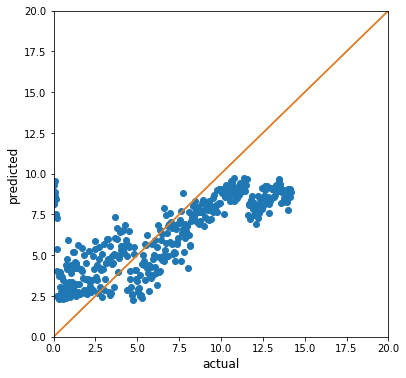

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(y_subset_test.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()